In [11]:
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn import datasets

# Visualización.
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. Dataset

El conjunto de datos CIRCLES consiste en puntos en un plano que forman dos círculos, de aquí el nombre de "circles". Cada círculo corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hace un gràfico para visualizar los dos círculos (con colores diferentes para cada grupo). 

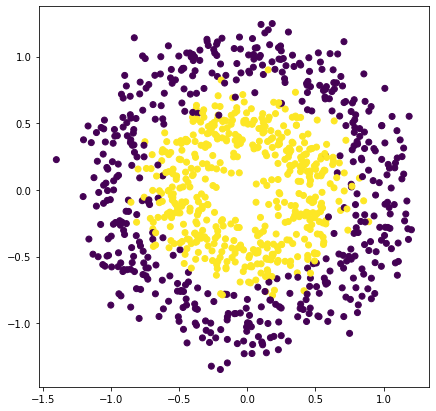

In [2]:
df = datasets.make_circles(n_samples=1000, factor=.5, noise=.15, random_state=42)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group, label = "sa")

Antes de aplicar ningún modelo, tenemos que separar los datos entre el conjunto de *train* y de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*.

In [3]:
random_state = 24

X_train, X_test, y_train, y_test = train_test_split(df[0], df[1], random_state=random_state, test_size = 0.2)

A lo largo del ejercicio aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una _meshgrid_ con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde. También veremos las areas de indecisión, casos en los que el modelo no se inclina ni hacia una clase ni hacia otra (o si que se inclina pero no lo tiene 100% claro), estas seran blanquinosas.

In [4]:
# Vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1 

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Dibujamos las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.4. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tree_model = DecisionTreeClassifier()


max_depth_range = [4,10]
min_samples_split_range = [2,10,20,50,100]

param_grid = dict(max_depth=max_depth_range, min_samples_split=min_samples_split_range)

grid = GridSearchCV(tree_model, param_grid, cv=4, scoring='accuracy', verbose=1)

grid_search=grid.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


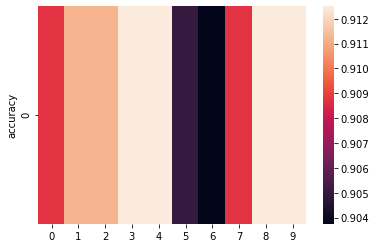

In [6]:
sns.heatmap([grid_search.cv_results_['mean_test_score']])
plt.ylabel('accuracy')
plt.show()

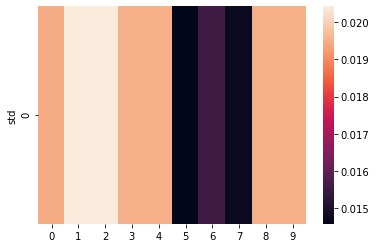

In [7]:
sns.heatmap([grid_search.cv_results_['std_test_score']])
plt.ylabel('std')
plt.show()

En el primer mapa de calor se observan los promedios de las precisiones cuando `max_depth` y `min_samples_split` toman los valores de [4,10] y [2,10,20,50,100] respectivamente. Los mejor resultado se obtuvo en el índices 3.

In [8]:
grid_search.best_params_

{'max_depth': 4, 'min_samples_split': 50}

In [9]:
tree_model = DecisionTreeClassifier(max_depth= 4, min_samples_split= 20)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)

In [12]:
confusion_matrix(y_test, y_pred)

array([[89, 10],
       [ 6, 95]], dtype=int64)

In [13]:
accuracy= accuracy_score(y_test,y_pred)
accuracy

0.92

<Figure size 1080x720 with 0 Axes>

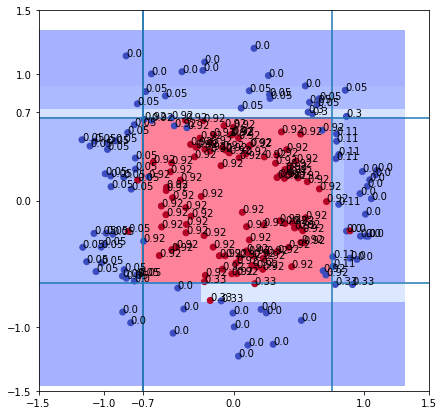

In [14]:
plt.figure(figsize=(15, 10))
plot_decision_boundaries(X_test[:, 0], X_test[:, 1], y_test, tree_model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02)


plt.xticks([-1.5,-0.7,-1,0, 1, 1.5])
plt.yticks([-1.5,0.7,-1,0, 1, 1.5])
plt.axvline(-0.7)
plt.axvline(0.75)
plt.axvline(-0.7)
plt.axhline(0.65)
plt.axhline(-0.65)

proba = tree_model.predict_proba(X_test)[:,1]
for x, y, prob in zip(X_test[:, 0], X_test[:, 1], proba):
    plt.text(x,y, round(prob, 2))

plt.show()

En el primer mapa de calor se observan los promedios de las precisiones cuando `max_depth` y `min_samples_split` toman los valores de [4,10] y [2,10,20,50,100] respectivamente. Los mejor resultado se obtuvo en el índices 3.

**¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?**

En el gráfico de fronteras de decisión se observa que los límites para que el algoritmo DecisionTree clasifique un registro como clase 1, este debe estar en el eje x entre los valores -0.7, y 0.75, y en el eje y entre los valores -0.65 y 0.65. 

La forma rectangular del área de decisión se debe a que el algoritmo corta los valores en ambos ejes para clasificar los registros.

**¿Cómo son las predicciones obtenidas sobre el conjunto de test?**

Los límites para clasificar un registro como clase 1 son los siguientes:

* En el eje x los valores deben estar entre -0.7, y 0.75 aproximadamente.
* En el eje y los valores deben estar entre -0.65 y 0.65 aproximadamente.


A continuación, predecimos el punto [-0.8, 0.5], como resultado obtenemos que pertenece a la clase 0, con una probabilidad de pertenecer a la clase 1 de 0.05. Esto se debe a que el valor de -0.8 está fuera del rango establecido por el modelo para categorizar como 1.

In [15]:
x_1, y_1 = -0.8, 0.5
tree_model.predict([[x_1, y_1]]), tree_model.predict_proba([[x_1, y_1]])

(array([0], dtype=int64), array([[0.94594595, 0.05405405]]))

### 1.5. Mejorando los árboles de decisión

En la práctica, casi nunca se utiliza un solo árbol de decisión, sino que se combinan muchos árboles para obtener mejores resultados. Hay dos maneras de combinar árboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ está basado en este concepto, la combinación de varios árboles de decisión, cada uno entrenado con una muestra diferente de los datos. La decisión final del clasificador combinado (la _random forest_) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
  
  - *__Boosting__*: se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificadas en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
  
Ambos métodos los estudiaremos más en detalle en la próxima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de árboles respecto un solo árbol.

Al tratarse de árboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso añadiremos un hiperparámetro más. Para simplificar, de los dos parámetros anteriores optimizaremos sólo `max_depth`:

  - `n_estimators`: número de árboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 8 y 12.

In [16]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

n_estimators_range = [50,100,200]
max_depth = [8,12]

param_grid = dict(n_estimators=n_estimators_range, max_depth=max_depth_range)

In [17]:
boosting_model = GradientBoostingClassifier()
grid = GridSearchCV(boosting_model, param_grid, cv=4, scoring='accuracy', verbose=1)

grid_search=grid.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.5s finished


In [18]:
grid_search.best_params_

{'max_depth': 4, 'n_estimators': 50}

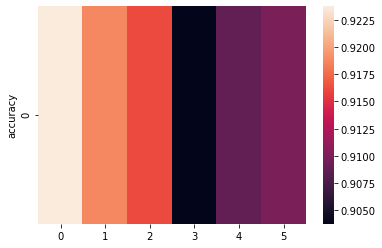

In [19]:
sns.heatmap([grid_search.cv_results_['mean_test_score']])
plt.ylabel('accuracy')
plt.show()

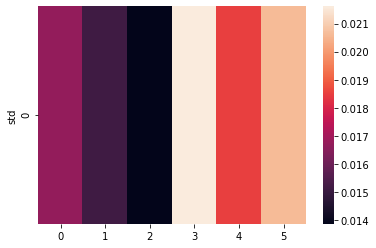

In [20]:
sns.heatmap([grid_search.cv_results_['std_test_score']])
plt.ylabel('std')
plt.show()

In [21]:
grid_search.cv_results_['mean_test_score'][grid_search.best_index_], grid_search.cv_results_['std_test_score'][grid_search.best_index_], 

(0.9237500000000001, 0.016723860200324535)